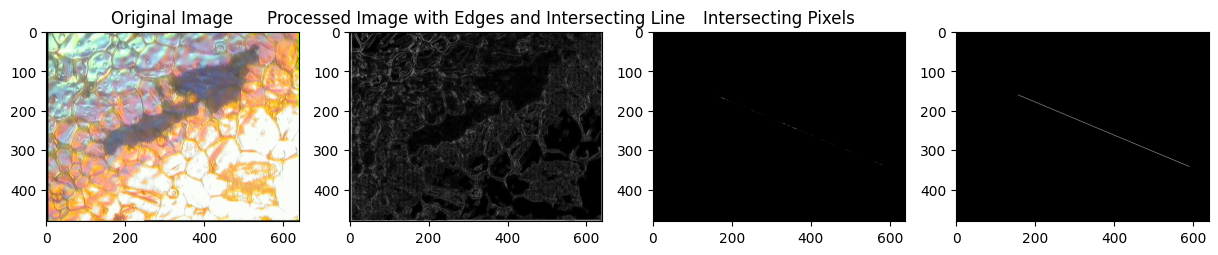

Iteration 1:
39.10900010085772


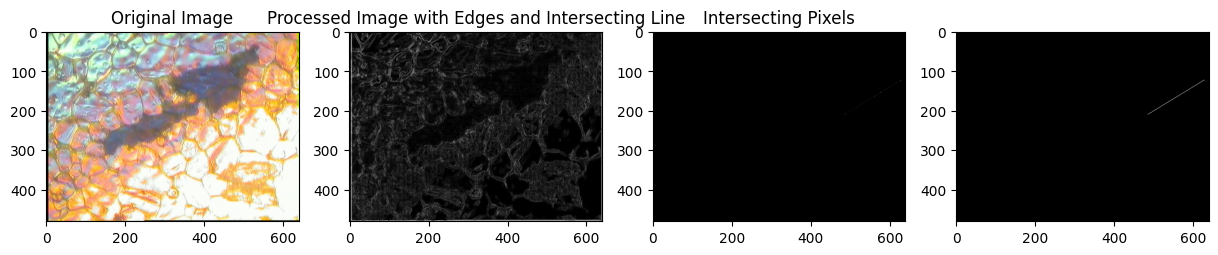

Iteration 2:
55.79526065098281


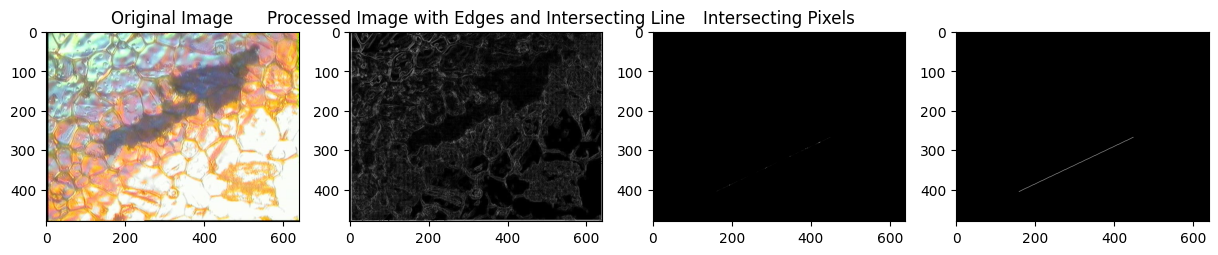

Iteration 3:
39.978509852169324


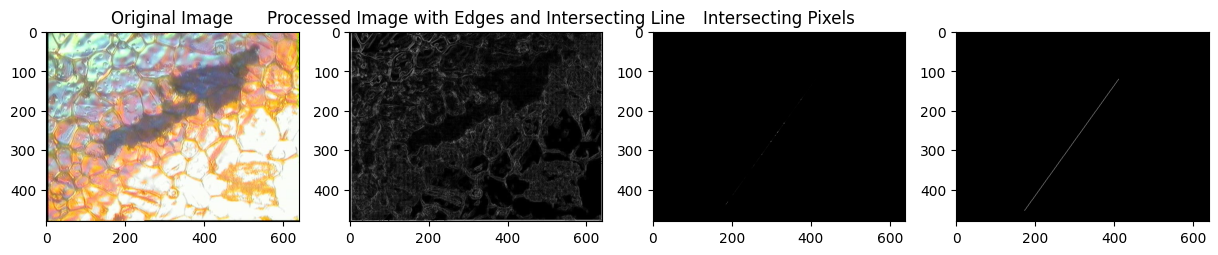

Iteration 4:
102.1236995021234


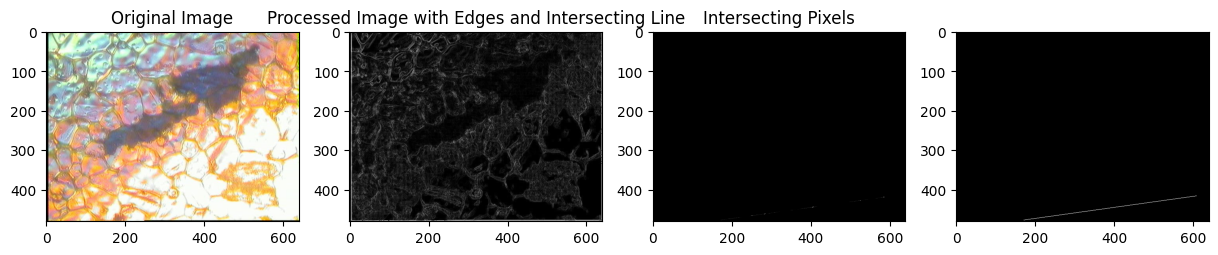

Iteration 5:
147.07896594082453


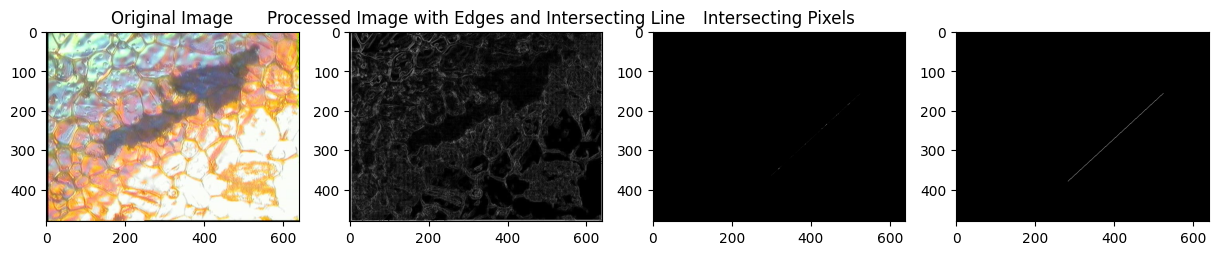

Iteration 6:
36.407332052218464


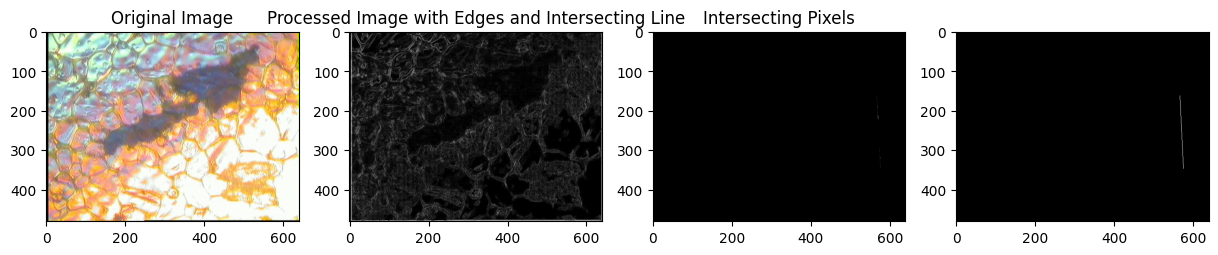

Iteration 7:
61.406659067057035


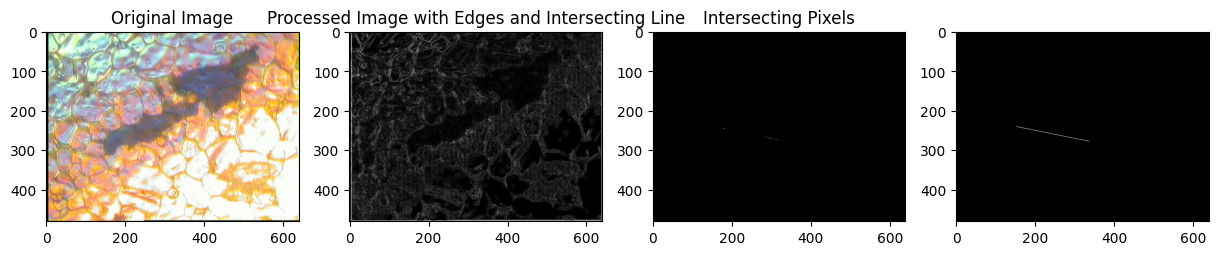

Iteration 8:
37.34059453195677


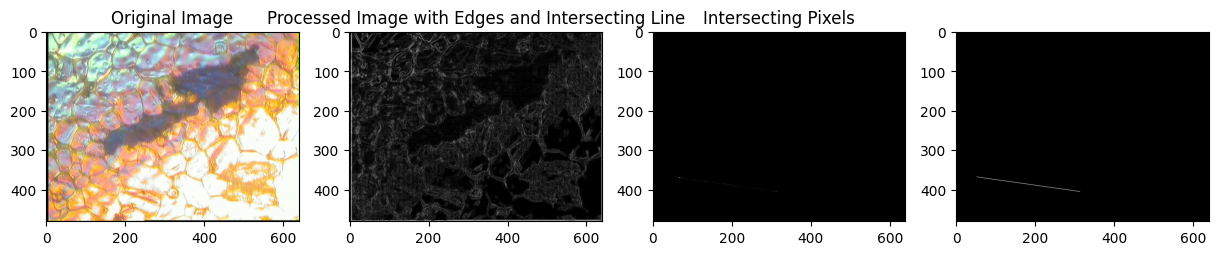

Iteration 9:
65.90238994148847


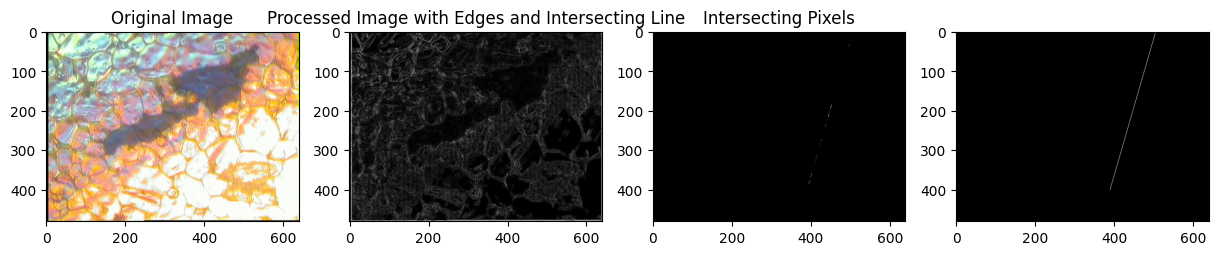

Iteration 10:
26.090063362322446
Average mean of values from 10 iteration  = 61.123247500200094


In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d

# Load the image
img = Image.open('./source/2h_milling1200C_2h.jpg')

# Convert the image to grayscale
gray = img.convert('L')

# Convert the grayscale image to a NumPy array
img_array = np.array(gray)



def calculate(img_array, iterations=10):
    values = [0 for _ in range(iterations)]
    for i in range(iterations):
        # Define the Sobel filter
        sobel_filter = np.array([[-1], [0], [1]])

        # Apply the Sobel filter to the image
        edge_x = np.abs(convolve2d(img_array, sobel_filter, mode="same"))
        edge_y = np.abs(convolve2d(img_array, sobel_filter.T, mode="same"))
        edge = edge_x + edge_y
        edge = edge.reshape(img_array.shape)
        # Draw a random line on the processed image
        h, w = edge.shape
        start_w = np.random.randint(w)
        end_w = np.random.randint(w)
        start_h = np.random.randint(h)
        end_h = np.random.randint(h)
        start_point = (start_w, start_h)
        end_point = (end_w, end_h)


        # Create a boolean mask of the pixels where the edge intersects with the line
        mask = np.zeros_like(edge, dtype=np.uint8)
        cv2.line(mask, start_point, end_point, 255, thickness=1)
        edge = edge.astype(np.uint8)

        # Get the intersecting pixels between the edge image and the line mask
        intersecting_pixels = cv2.bitwise_and(edge, mask)
        intersecting_pixels[intersecting_pixels > 60] = 255

        # Modify the color of the intersecting pixels in the edge array
        edge[intersecting_pixels == 255] = 127

        # Display the original image, the processed image with edges, and the processed image with edges and a line
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))
        axs[0].imshow(img)
        axs[0].set_title('Original Image')
        axs[1].imshow(edge, cmap='gray')
        axs[1].set_title('Processed Image with Edges and Intersecting Line')

        # Display the mask image with the intersecting pixels
        axs[2].imshow(intersecting_pixels, cmap='gray')
        axs[2].set_title('Intersecting Pixels')
        axs[3].imshow(mask, cmap="gray")
        plt.show()

        # Save the modified image
        img_output = Image.fromarray(intersecting_pixels)
        img_output.save("output.jpg")

        newimg = Image.open('./output.jpg')
        newimg = newimg.convert("L")

        newimg_arr = np.array(newimg)
        cross_counter = np.sum(newimg_arr == 255)
        np.savetxt('output.txt', newimg_arr, fmt='%s')



        x = np.abs(end_h - start_h)
        y = np.abs(end_w - start_w)
        line_length = np.sqrt(x*x + y*y)
        if(cross_counter != 0):
            print(f"Iteration {i+1}:")
            print(line_length/cross_counter)
            values[i] = line_length/cross_counter
        else:
            values[i] = 0
    
    print(f"Average mean of values from {iterations} iteration  = {np.mean(values)}")

calculate(img_array)

mask_resized shape: (257, 257, 3) mask dtype: uint8
gray shape: (257, 257, 3) gray dtype: uint8
